In [1]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random
from sklearn.model_selection import train_test_split
import time
from joblib import Parallel, delayed
import pandas as pd
import sys
import os
import seaborn as sns 
current = os.path.dirname(os.path.realpath('plotting.py'))
parent = os.path.dirname(current)
sys.path.append(parent)
import functions.plotting as NNplt
from functions.rnn_cryptic import generate_sequences, convert_seq2inputs,\
                                  pad_seqs_2step, pad_seqs_1step, calculate_output, onehot2seq 

from sklearn.metrics import r2_score
import math

In [14]:
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)
        self.initialize_weights()
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]
    
    def initialize_weights(self):
        y = 1/math.sqrt(hidden_size)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, 0.01)


def train(sequence,label,model,optimizer,criterion):
    model.train()
    optimizer.zero_grad()
    #Read each cue in and keep hidden state for next cue
    hidden = model.initHidden()
    batch_out = []
    for batchseq in sequence:
        for i in range(len(batchseq)):
            output, hidden = model.forward(batchseq[i], hidden)
        batch_out.append(output)
        #Compare final output to target
    batch_out = torch.cat(batch_out)
    loss = criterion(batch_out,label)#.long())

    #Back-propagate
    loss.backward()
    optimizer.step()

    return batch_out, loss.item()

def run_acc(model,optimizer,criterion, train_data, test_data, epochs, verbose = False):
    
    loss_history = np.empty((0,1))
    all_accs = np.empty((0,len(test_data)))
    for epoch in range(epochs):
        lossTotal = 0
        for i, (x,y) in enumerate(train_data):
            output, loss = train(x,y,model,optimizer,criterion)
            lossTotal += loss # add MSE -> sum of square errors 
        loss_history = np.vstack([loss_history, lossTotal])
        acc = test_acc(model, test_data, hidden_size)
        all_accs = np.vstack([all_accs,acc])

    return loss_history, all_accs

def test_acc(model, testdata, hidden_size, verbose = False):
    model.eval()
    accs = np.empty((1, 0))
    for testset in testdata:
        batch_correct = []
        for x,y in testset:
            correct = 0
            for i in range(len(x)):
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                correct += sum(torch.round(y[i]) == torch.round(y_hat)).item()
            batch_correct.append(correct/len(y))
        acc = np.mean(batch_correct)
        accs = np.append(accs, [acc])
    if verbose:
        print('test accuracy: %f ' % (acc))
    return accs

def test_preds(model, testdata, hidden_size, suffix = ''):
    model.eval()
    preds = []
    labs = []
    trials = []
    accs = []
    for testset in testdata:
        batch_correct = []
        for x,y in testset:
            for i in range(len(x)):
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                preds.append(y_hat.detach().item())
                labs.append(y[i].detach().item())
                correct = sum(torch.round(y[i]) == torch.round(y_hat)).item()
                accs.append(correct)
            trials.append(str(onehot2seq(x)))
    df = pd.DataFrame({'trial':trials, 'label'+suffix:labs, 'pred'+suffix: preds, 'acc'+suffix: accs})
    return df 


def shuffle_weights(model):
    model2 = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    mod_dict = model.state_dict()
    shuffled_dict = {layer: shuffle_tensor(val) for layer, val in mod_dict.items()}
    model2.load_state_dict(shuffled_dict)
    return model2

def shuffle_tensor(t):
    idx = torch.randperm(t.nelement())
    t = t.view(-1)[idx].view(t.size())
    return t

def run_sim(train_trials, test_trials):
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, train_trials, test_trials, epochs)
    return loss1, acc1, model

def run_sims(i, train_trials, test_trials):
    print('########## rep', i, '#########')
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, train_trials[0], test_trials, epochs)
    loss2, acc2 = run_acc(model,optimizer,criterion, train_trials[1], test_trials, epochs)
    losses = np.vstack([loss1,loss2])
    accs = np.vstack([acc1,acc2])
    return losses, accs, model

def change_padder(seqs, cue_dict, xval):
    """ changes value of X from zero to a new value
        and recalculates sequence output"""
    cue_dict['X'] = xval
    inps = [s[:-1] for s in seqs]
    for inp in inps:
        inp.append(calculate_output(inp, cue_dict, bidmas = False))

    return inps, cue_dict

def change_dict(seqs, new_dict):
    """ recalculates sequence output"""
    inps = [s[:-1] for s in seqs]
    for inp in inps:
        inp.append(calculate_output(inp, new_dict, bidmas = False))

    return inps, cue_dict

def predcorr(mods, tests):
    dfs1 = []
    for i in range(len(mods)):
        df = test_preds(mods[i], [tests[i]], hidden_size)
        dfs1.append(df)
        all_dfs1 = pd.concat(dfs1) 
        preds, labs = all_dfs1['pred'], all_dfs1['label']
        xy = np.arange(np.min(preds)-1, np.max(labs)+1, 0.1)

        for d in dfs1:
            plt.scatter(d['label'], d['pred'])
        plt.plot(xy,xy)
        plt.xlabel('Ground truth')
        plt.ylabel('Model prediction')
        plt.title('with primitive training, R^2 = ' + str(round(r2_score(all_dfs1['pred'],all_dfs1['label']), 2)) )
    
    return all_dfs1.groupby(['trial']).mean().sort_values(by = 'acc' , ascending=False)

# ----------
# plotting
# ----------

def plotNNs(loss_arrays, acc_arrays, labels, colors, title, shift = 0):

    fig, axs = plt.subplots(2, 1)
    loss_cols = ['blue', 'darkblue']
    loss_labs = ['loss_with_primitive', 'loss_without_primitive']
    for i, arr in enumerate(loss_arrays):
        x = np.arange(0,arr.shape[0],1) + shift
        mn = arr.mean(axis=1)
        errs = arr.std(axis=1)
        
        axs[0].plot(x, mn, label = loss_labs[i], color = loss_cols[i])
        axs[0].fill_between(x, mn - errs, mn + errs, alpha = 0.3, facecolor = loss_cols[i])
    
    axs[0].set_xlabel('epoch')
    axs[0].set_ylabel('loss')
    axs[0].legend()
    
    for i, arr in enumerate(acc_arrays):
        x = np.arange(0,arr.shape[0],1) + shift
        mn = arr.mean(axis=1)
        errs = arr.std(axis=1)
        
        axs[1].plot(x, mn, label = labels[i], color = colors[i])
        axs[1].fill_between(x, mn - errs, mn + errs, alpha = 0.3, facecolor = colors[i])
    
    axs[1].set_xlabel('epoch')
    axs[1].set_ylabel('accuracy')
    axs[1].legend()

    fig.suptitle(title, fontsize=10)

In [15]:
def generate_other(operators, inputs, init_values, rep = 1):
    # remove init form inputs
    
    seq = []
    combi_operators = list(itertools.product(operators, repeat=2))
    for _ in range(rep):
        for init in init_values:
            input_ids = [val for val in inputs if val != init]
            combi_inputcue = list(itertools.combinations(input_ids, r=2))
            cue = random.choice(combi_inputcue)
            op = random.choice(combi_operators)
            trial = [init,*zip(tuple(op), cue)]
            trial.append(calculate_output(trial, cue_dict, False))
            seq.append(trial)

    return seq

def generate_self(operators, inputs, rep = 1):
    seq = []
    for _ in range(rep):
        for inp in inputs:
            trial = generate_sequences(operators, inp, len_seq = 2, cue_dict = cue_dict, init_values = inp)
            seq += trial
    return seq

def generate_dummy(operators, inputs, init_values, rep = 1):
    # remove init form inputs
    
    seq = []
    combi_operators = list(itertools.product(operators, repeat=2))
    for _ in range(rep):
        for init in init_values:
            input_ids = [val for val in inputs if val != init]
            inp = random.choice(input_ids)
            cue = (inp, inp)
            op = random.choice(combi_operators)
            trial = [init,*zip(tuple(op), cue)]
            trial.append(calculate_output(trial, cue_dict, False))
            seq.append(trial)

    return seq

def generate_other_1step(operators, inputs, init_values):
    # remove init form inputs
    
    seq = []
    for init in init_values:
        input_ids = [val for val in inputs if val != init]
        cue = random.sample(input_ids, 2)
        op = random.choice(operators)
        trial = [init,(op, cue[0])]
        trial.append(calculate_output(trial, cue_dict, False))
        seq.append(trial)
        op = random.choice(operators)
        trial = [cue[1],(op, init)]
        trial.append(calculate_output(trial, cue_dict, False))
        seq.append(trial)

    return seq

def generate_other(op, inputs, init_values):

    seq = []
    for inp in inputs:
        inits = [val for val in init_values if val != inp]
        init = random.choice(inits)
        trial = [init,(op, inp)]
        trial.append(calculate_output(trial, cue_dict, False))
        seq.append(trial)
        
    return seq


# Parameters and Setup

In [16]:
def run_exp1(trainseqs_old, testseqs_old):
    
    total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
    all_syms = total_syms[:num_inputs]
    all_input_vals = list(np.arange(2,18))
    input_vals = random.sample(all_input_vals,num_inputs)
    # randomly select values for each input
    for i, s in enumerate(all_syms):
        cue_dict[s] = input_vals[i]
    
    # load data for primitive training
    trainseqs, cd = change_dict(trainseqs_old, cue_dict)
    train_inputs = convert_seq2inputs(trainseqs, num_classes=num_classes, seq_len=5)
    trainset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
    testseqs, cd = change_dict(testseqs_old, cue_dict)
    test_inputs = convert_seq2inputs(testseqs, num_classes=num_classes, seq_len=5)
    testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)

    # run primitive training RNN
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, trainset, [trainset, testset], epochs)

    
    return {'cue_dict':cue_dict, 'loss':loss1, 'acc':acc1, 'mod': model, 'test': testset}


def run_exp2(trainseqs_old1, trainseqs_old2, testseqs_old):
    
    total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
    all_syms = total_syms[:num_inputs]
    all_input_vals = list(np.arange(2,18))
    input_vals = random.sample(all_input_vals,num_inputs)
    # randomly select values for each input
    for i, s in enumerate(all_syms):
        cue_dict[s] = input_vals[i]
    
    # load data for primitive training
    trainseqs1, cd = change_dict(trainseqs_old1, cue_dict)
    train_inputs = convert_seq2inputs(trainseqs1, num_classes=num_classes, seq_len=5)
    trainset1 = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
    trainseqs2, cd = change_dict(trainseqs_old2, cue_dict)
    train_inputs = convert_seq2inputs(trainseqs2, num_classes=num_classes, seq_len=5)
    trainset2 = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
    testseqs, cd = change_dict(testseqs_old, cue_dict)
    test_inputs = convert_seq2inputs(testseqs, num_classes=num_classes, seq_len=5)
    testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)

    # run primitive training RNN
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, trainset1, [trainset1, trainset2, testset], epochs)
    loss2, acc2 = run_acc(model,optimizer,criterion, trainset2, [trainset1, trainset2, testset], epochs)
    losses = np.vstack([loss1, loss2])
    accs = np.vstack([acc1, acc2])
    return {'cue_dict':cue_dict, 'loss':losses, 'acc':accs, 'mod': model, 'train2':trainset2, 'test': testset}

# Experiments

With P
1. Only "Other" permutations of 1 step (B+C+X),(C-D-X) ... + p (A + X + X), (A - X - X)
2. 
3. 




In [24]:
# params

# data
num_classes = 22
batchsize=1

# RNN specs
input_size = num_classes
output_size = 1
num_layers = 2
hidden_size = 10
learningRate = 0.005

## running params
epochs = 1000
num_sims = 8
num_inputs = 5

In [18]:
total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
all_syms = total_syms[:num_inputs]
all_input_vals = list(np.arange(2,18))
input_vals = random.sample(all_input_vals,num_inputs)
# randomly select values for each input
cue_dict = {'X':0}
for i, s in enumerate(all_syms):
    cue_dict[s] = input_vals[i]
    
print(cue_dict)

{'X': 0, 'A': 16, 'B': 9, 'C': 5, 'D': 13, 'E': 11}


# Multiple ops pretraining. How to get to +/- 2 step?

In [19]:
syms = all_syms[1:]

In [20]:
# Check addition
epochs = 2000

time:  2.0317608674367267


,label,pred,acc
trial,,,
"['E', '+', 'B', '+', 'B']",23.375,23.354850,1.000
"['E', '+', 'E', '+', 'B']",22.000,21.975304,1.000
"['C', '+', 'E', '+', 'C']",20.875,20.634437,0.875
"['D', '+', 'C', '+', 'D']",29.250,29.062198,0.875
"['E', '+', 'D', '+', 'B']",26.250,26.397600,0.875
"['D', '+', 'E', '+', 'E']",24.875,24.684981,0.750
"['B', '+', 'B', '+', 'C']",23.500,22.577307,0.625
"['B', '+', 'C', '+', 'E']",22.125,20.950160,0.625
"['D', '+', 'D', '+', 'E']",29.125,28.856731,0.625


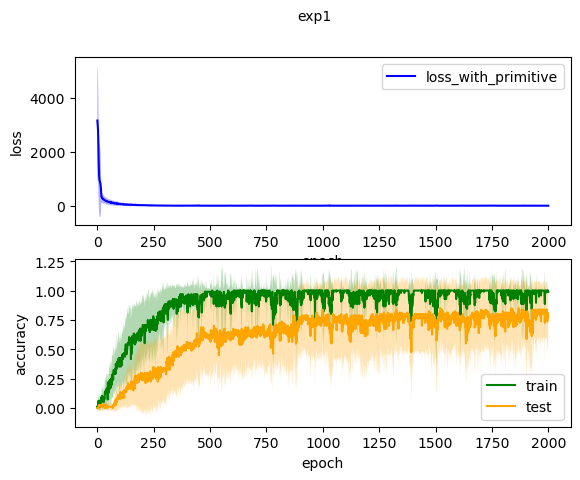

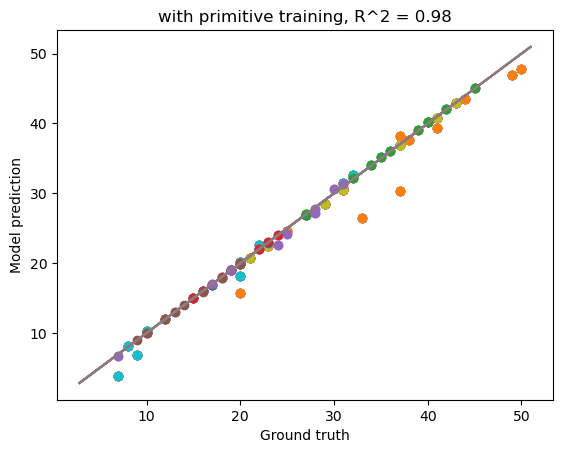

In [21]:
p_add = pad_seqs_1step(syms, cue_dict, padder = ('+', 'X'))
train_add = pad_seqs_2step(generate_other('+', syms, syms), padder = ('+', 'X'))
trainseqs = p_add + train_add
testseqs = random.sample(generate_sequences(['+'], syms, \
                                 len_seq = 2, cue_dict = cue_dict, init_values = syms), 10)

t1 = time.time()
res1  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res1])
acc_train = np.array([r['acc'][:,0] for r in res1]).T
acc_test = np.array([r['acc'][:,1] for r in res1]).T
mods = [r['mod'] for r in res1]
tests = [r['test'] for r in res1]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'exp1', shift = 0)
plt.figure()
predcorr(mods, tests)

In [87]:
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)
        self.initialize_weights()
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.leaky_relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, 0.1)

In [88]:
# Check subtraction
hidden_size=5
num_layers=2
epochs = 3000

time:  3.5459723353385924


,label,pred,acc
trial,,,
"['B', '-', 'E', '-', 'B']",-8.000,-3.559879,0.125
"['C', '-', 'B', '-', 'E']",-7.125,-3.998445,0.125
"['E', '-', 'D', '-', 'D']",-11.500,-5.363340,0.125
"['E', '-', 'E', '-', 'C']",-11.375,-6.236837,0.125
"['E', '-', 'E', '-', 'D']",-9.750,-5.040467,0.125
"['B', '-', 'C', '-', 'B']",-11.375,-5.757334,0.000
"['B', '-', 'D', '-', 'D']",-9.000,-2.452061,0.000
"['C', '-', 'B', '-', 'B']",-9.625,-6.642610,0.000
"['C', '-', 'D', '-', 'E']",-6.375,-2.709781,0.000


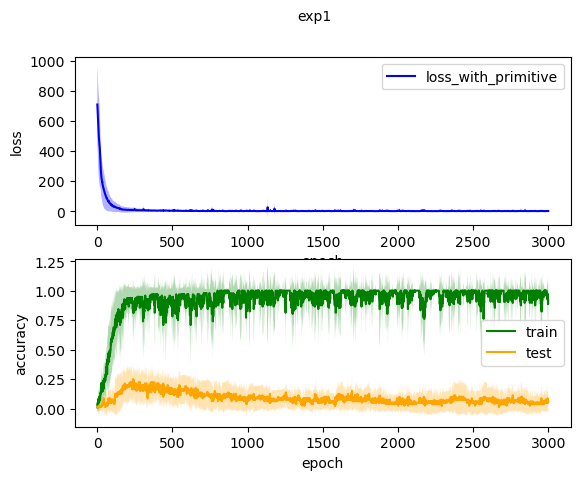

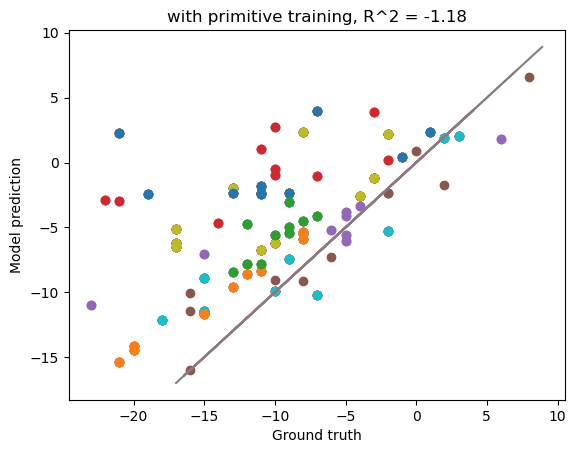

In [89]:
p_add = pad_seqs_1step(syms, cue_dict, padder = ('-', 'X'))
train_add = pad_seqs_2step(generate_other('-', syms, syms), padder = ('-', 'X'))
trainseqs = train_add + p_add
testseqs = random.sample(generate_sequences(['-'], syms, \
                                 len_seq = 2, cue_dict = cue_dict, init_values = syms), 10)

t1 = time.time()
res1  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res1])
acc_train = np.array([r['acc'][:,0] for r in res1]).T
acc_test = np.array([r['acc'][:,1] for r in res1]).T
mods = [r['mod'] for r in res1]
tests = [r['test'] for r in res1]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'exp1', shift = 0)
plt.figure()
predcorr(mods, tests)

In [86]:
testseqs

[['B', ('-', 'D'), ('-', 'C'), -9],
 ['B', ('-', 'B'), ('-', 'C'), -5],
 ['B', ('-', 'C'), ('-', 'C'), -1],
 ['C', ('-', 'C'), ('-', 'B'), -9],
 ['E', ('-', 'D'), ('-', 'E'), -13],
 ['C', ('-', 'E'), ('-', 'C'), -11],
 ['C', ('-', 'D'), ('-', 'E'), -19],
 ['B', ('-', 'B'), ('-', 'D'), -13],
 ['D', ('-', 'E'), ('-', 'C'), -3],
 ['E', ('-', 'D'), ('-', 'D'), -15]]

In [73]:
p_add = pad_seqs_1step(all_syms, cue_dict, padder = ('+', 'X'))
p_sub = pad_seqs_1step(all_syms, cue_dict, padder = ('-', 'X'))
train_add = pad_seqs_2step(generate_other('+', all_syms[1:], all_syms[1:]), padder = ('+', 'X'))
train_sub = pad_seqs_2step(generate_other('-', all_syms[1:], all_syms[1:]), padder = ('-', 'X'))
trainseqs1 = p_add + p_sub + train_add + train_sub
trainseqs2 = random.sample(generate_sequences(['+', '-'], all_syms[1:], \
                                 len_seq = 2, cue_dict = cue_dict, init_values = all_syms[1:]), 20)
testseqs = test_other(['+', '-'], 'A', all_syms[1:], rep = 10)

,label,pred,acc
trial,,,
"['B', '+', 'C', '+', 'A']",28.875,29.850226,0.125
"['C', '+', 'E', '+', 'A']",29.750,33.107196,0.125
"['D', '+', 'B', '-', 'A']",10.375,10.182434,0.125
"['E', '+', 'A', '+', 'D']",30.000,31.709115,0.125
"['B', '+', 'A', '+', 'B']",31.125,29.690242,0.000
"['B', '+', 'A', '-', 'E']",8.500,8.393145,0.000
"['B', '-', 'A', '+', 'E']",13.250,5.835708,0.000
"['B', '-', 'C', '-', 'A']",-7.125,-3.585875,0.000
"['D', '-', 'A', '-', 'E']",-12.250,-5.714125,0.000


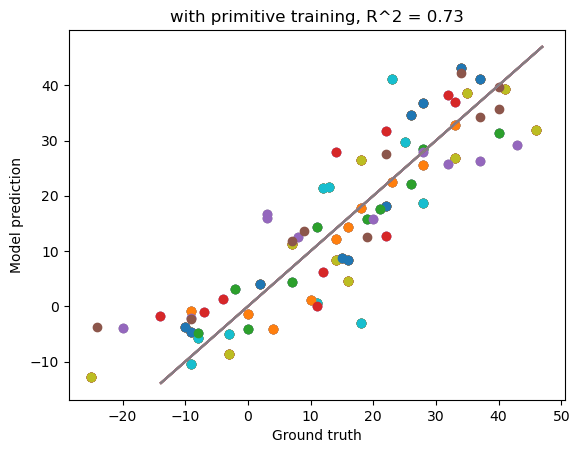

In [80]:
t1 = time.time()
res1  = Parallel(n_jobs = -1)(delayed(run_exp2)(trainseqs1, trainseqs2, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res1])
acc_train1 = np.array([r['acc'][:,0] for r in res1]).T
acc_train2 = np.array([r['acc'][:,1] for r in res1]).T
acc_test = np.array([r['acc'][:,2] for r in res1]).T
mods = [r['mod'] for r in res1]
train2 = [r['train2'] for r in res1]
tests = [r['test'] for r in res1]

plotNNs([losses], [acc_train1, acc_train2, acc_test], labels = ['train1','train2', 'test'],\
        colors = ['red','green', 'orange'], title = '')

predcorr(mods, tests)

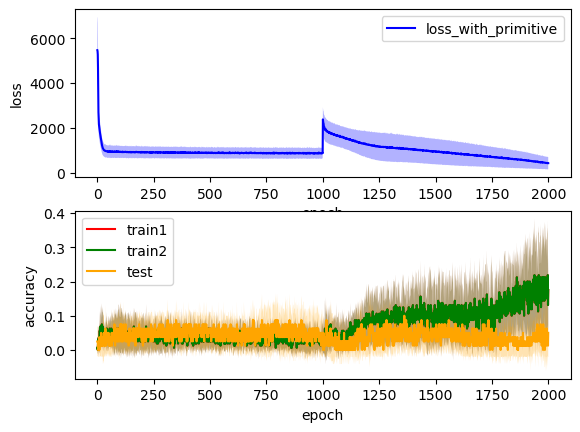

In [86]:
plotNNs([losses], [acc_train1, acc_train2, acc_test], labels = ['train1','train2', 'test'],\
        colors = ['red','green', 'orange'], title = '')


In [87]:
p_add = pad_seqs_1step(all_syms, cue_dict, padder = ('+', 'X'))
p_sub = pad_seqs_1step(all_syms, cue_dict, padder = ('-', 'X'))

trainseqs = p_add + p_sub + generate_sequences(['+', '-'], all_syms[1:], \
                                 len_seq = 2, cue_dict = cue_dict, init_values = all_syms[1:])

testseqs = test_other(['+', '-'], 'A', all_syms[1:], rep = 10)


time:  10.06404086748759


,label,pred,acc
trial,,,
"['B', '-', 'A', '+', 'B']",12.375,12.730817,0.125
"['C', '+', 'C', '-', 'A']",15.875,18.324391,0.125
"['C', '-', 'A', '+', 'E']",11.375,11.578110,0.125
"['D', '+', 'A', '-', 'C']",4.500,12.482810,0.125
"['D', '-', 'B', '+', 'A']",6.250,15.230556,0.125
"['D', '-', 'D', '+', 'A']",7.625,16.657524,0.125
"['E', '+', 'A', '-', 'C']",3.125,11.274818,0.125
"['E', '+', 'D', '-', 'A']",8.250,10.630122,0.125
"['C', '-', 'A', '-', 'B']",-5.875,-5.121510,0.000


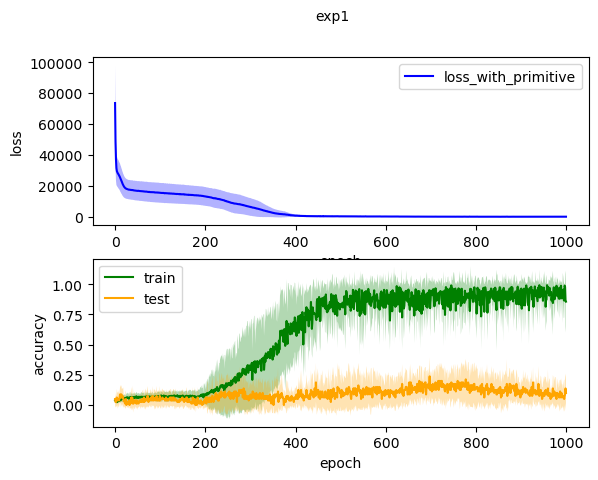

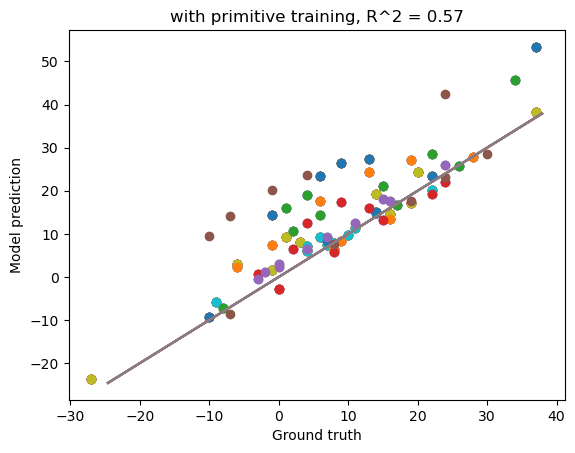

In [88]:

t1 = time.time()
res1  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res1])
acc_train = np.array([r['acc'][:,0] for r in res1]).T
acc_test = np.array([r['acc'][:,1] for r in res1]).T
mods = [r['mod'] for r in res1]
tests = [r['test'] for r in res1]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'exp1', shift = 0)
plt.figure()
predcorr(mods, tests)

time:  1.004219082991282


,label,pred,acc
trial,,,
"['E', '+', 'A', '-', 'E']",7.875,12.157560,0.125
"['B', '-', 'A', '-', 'E']",-11.250,1.134781,0.000
"['B', '-', 'D', '+', 'A']",5.750,3.624142,0.000
"['C', '+', 'A', '+', 'C']",24.375,14.183428,0.000
"['C', '+', 'A', '-', 'E']",5.375,12.913832,0.000
"['D', '+', 'A', '-', 'E']",6.625,16.408838,0.000
"['D', '+', 'B', '+', 'A']",24.750,17.789566,0.000
"['E', '+', 'A', '-', 'B']",11.250,12.078220,0.000
"['E', '+', 'C', '+', 'A']",26.875,13.391614,0.000


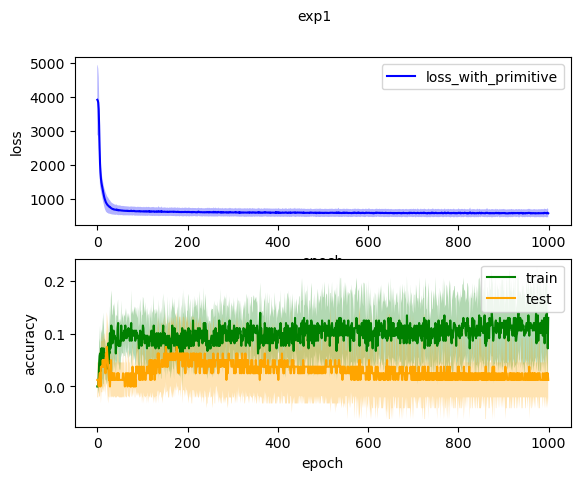

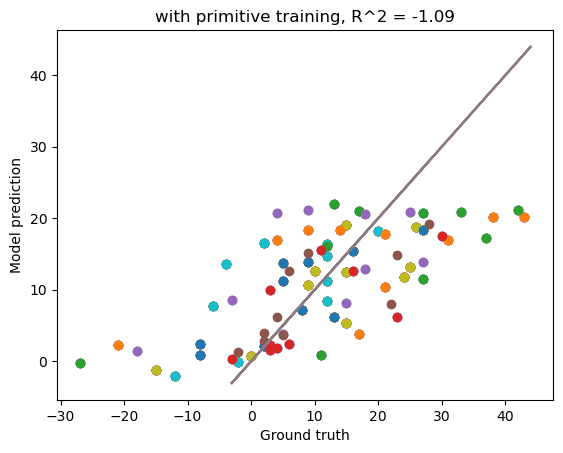

In [44]:
p_add = pad_seqs_1step(all_syms, cue_dict, padder = ('+', 'X'))
p_sub = pad_seqs_1step(all_syms, cue_dict, padder = ('-', 'X'))
train_add = pad_seqs_2step(generate_other('+', all_syms[1:], all_syms[1:]), padder = ('+', 'X'))
train_sub = pad_seqs_2step(generate_other('-', all_syms[1:], all_syms[1:]), padder = ('-', 'X'))
trainseqs = p_add + p_sub + train_add + train_sub
testseqs = test_other(['+', '-'], 'A', all_syms[1:], rep = 10)

t1 = time.time()
res1  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res1])
acc_train = np.array([r['acc'][:,0] for r in res1]).T
acc_test = np.array([r['acc'][:,1] for r in res1]).T
mods = [r['mod'] for r in res1]
tests = [r['test'] for r in res1]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'exp1', shift = 0)
plt.figure()
predcorr(mods, tests)

# 2 Min set +/-, test; test mixed 2 step

In [48]:
p_add = pad_seqs_1step(all_syms, cue_dict, padder = ('+', 'X'))
p_sub = pad_seqs_1step(all_syms, cue_dict, padder = ('-', 'X'))
train_add = pad_seqs_2step(generate_other('+', all_syms[1:], all_syms[1:]), padder = ('+', 'X'))
train_sub = pad_seqs_2step(generate_other('-', all_syms[1:], all_syms[1:]), padder = ('-', 'X'))
trainseqs = p_add + p_sub + train_add + train_sub
testseqs = random.sample(generate_sequences(ops, all_syms[1:], len_seq = 2, cue_dict = cue_dict, init_values = all_syms[1:]), 15)

time:  1.0169461329778036


,label,pred,acc
trial,,,
"['C', '+', 'C', '-', 'B']",7.500,7.651201,0.125
"['E', '+', 'E', '-', 'C']",12.875,14.133553,0.125
"['E', '-', 'E', '+', 'B']",9.250,6.634890,0.125
"['B', '+', 'B', '+', 'B']",27.750,16.473401,0.000
"['B', '+', 'C', '+', 'B']",26.875,15.678103,0.000
"['B', '+', 'D', '+', 'E']",30.500,17.031269,0.000
"['B', '+', 'D', '-', 'D']",9.250,15.545123,0.000
"['C', '-', 'C', '-', 'C']",-8.375,1.089835,0.000
"['C', '-', 'D', '+', 'C']",6.125,3.558082,0.000


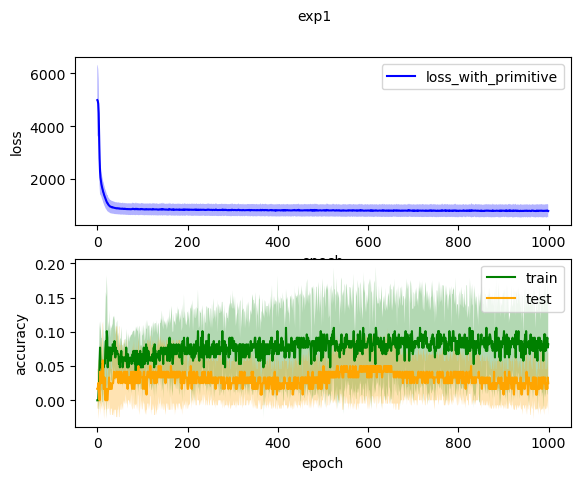

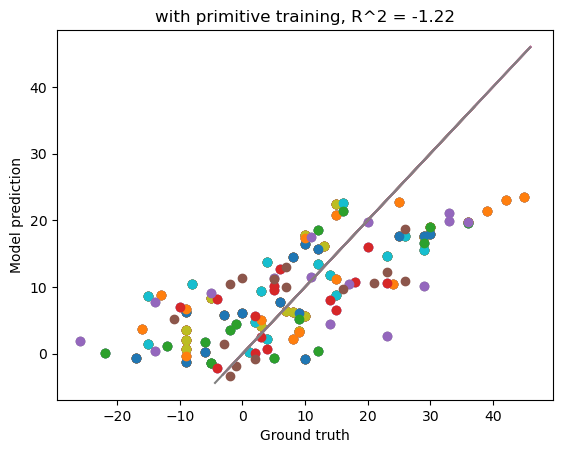

In [53]:
t1 = time.time()
res2  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res2])
acc_train = np.array([r['acc'][:,0] for r in res2]).T
acc_test = np.array([r['acc'][:,1] for r in res2]).T
mods = [r['mod'] for r in res2]
tests = [r['test'] for r in res2]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'exp1', shift = 0)
plt.figure()
predcorr(mods, tests)

In [59]:
p_add = pad_seqs_1step(all_syms, cue_dict, padder = ('+', 'X'))
train_add = pad_seqs_2step(generate_other('+', all_syms[1:], all_syms[1:]), padder = ('+', 'X'))
train_sub = pad_seqs_2step(generate_other('-', all_syms[1:], all_syms[1:]), padder = ('-', 'X'))
trainseqs = p_add + train_add + train_sub
testseqs = random.sample(generate_sequences(['+'], all_syms[1:], len_seq = 2, cue_dict = cue_dict, init_values = all_syms[1:]), 15)

time:  0.8117952346801758


,label,pred,acc
trial,,,
"['C', '+', 'E', '+', 'E']",29.000,19.753984,0.125
"['D', '+', 'C', '+', 'E']",26.125,14.892780,0.125
"['B', '+', 'B', '+', 'E']",31.250,21.730773,0.000
"['B', '+', 'D', '+', 'B']",28.375,20.308348,0.000
"['B', '+', 'E', '+', 'E']",31.375,21.934077,0.000
"['C', '+', 'B', '+', 'E']",28.875,19.550679,0.000
"['D', '+', 'B', '+', 'B']",28.375,16.030978,0.000
"['D', '+', 'D', '+', 'C']",23.250,14.553235,0.000
"['D', '+', 'D', '+', 'D']",22.875,14.542351,0.000


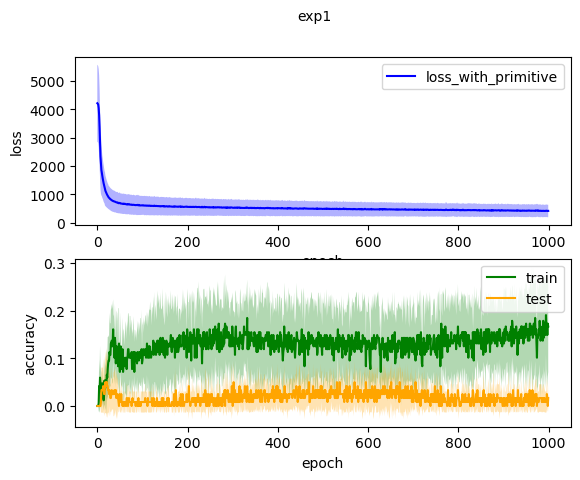

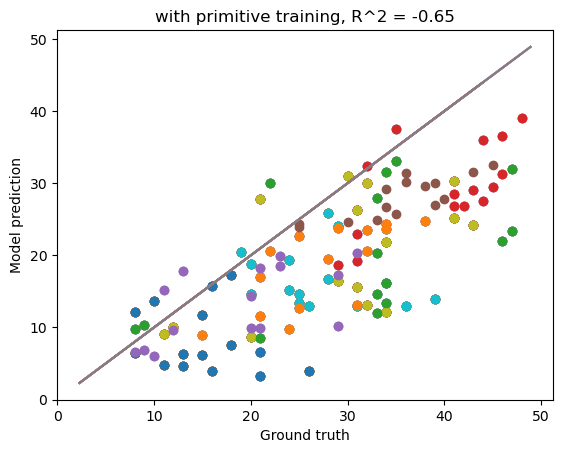

In [60]:
t1 = time.time()
res2  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res2])
acc_train = np.array([r['acc'][:,0] for r in res2]).T
acc_test = np.array([r['acc'][:,1] for r in res2]).T
mods = [r['mod'] for r in res2]
tests = [r['test'] for r in res2]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'exp1', shift = 0)
plt.figure()
predcorr(mods, tests)